# Tutorial 8 (Introduction to AI)

# Convolutional Neural Networks

# Part 1

In this tutorial we will build a convolutional neural network (CNN) to recognise the small 8x8 digit images from SciKit-Learn, which we have used in several exercises already.

CNNs set up a series of convolutions, structurally a series of filters that apply to images.  The results of applying these is then reduced in size using pooling layers, before the results is passed to one or more standard fully connected feedforward layers.

The network is then trained using labelled data using backpropagation as normal.  The result of training these deep networks is to learn values for both the standard fully connected feedforward layers and for the filters defined in the convolutional layers.

First of all, load libraries that will be used throughout this tutorial.

In [12]:
from sklearn.datasets import load_digits
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.keras.utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import io
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

Next, load the dataset.  In this exercise we are working directly with the images, not the flattened pixels given by digits.data that we have used previously.  

We are building a classifier, so the output is a class.  As we have seen previously, classes are dealt with in neural network by using a one-hot encoding to labels, and this is achieved below using the Keras builtin. 

In [2]:
#load the digits dataset from sklearn
digits = load_digits()

X = digits.images 
y = digits.target

#use the keras built in to ensure the targets are categories
y = tensorflow.keras.utils.to_categorical(y)

#if you want to check what this looks like, uncomment the below
#print(X[:5])
#print(y[:5])

As usual, the data is split into training and testing.  

As we shall see shortly, the neural network expects a tensor as an input.  Colour images are typically presented as RGB (or HSV) values, so each pixel is a triple, hence the data is in three dimensions.  Here we are working with greyscale images, but the image structure still needs to be a tensor.  Hence below the dimension is raised (essentially putting each greyscale pixel value into a list).

In [3]:
#split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=42)

#2d matrix
print(X_train[0][0])

X_train = np.expand_dims(X_train, axis=3)
X_test = np.expand_dims(X_test, axis=3)

#3d tensor
print(X_train[0][0])

[ 0.  0.  2. 15. 15. 16. 11.  0.]
[[ 0.]
 [ 0.]
 [ 2.]
 [15.]
 [15.]
 [16.]
 [11.]
 [ 0.]]


Convolutional neural networks can have quite a high number of parameters, so in some cases you might want to gather together values in a definitions section.  Here we have just three.

In [4]:
num_classes = y.shape[1]
save_dir = './' 
model_name = 'ex8Part1_trained_model.h5'

A convolutional neural network in Keras is defined with the Sequential framework.

These deep networks are not fully connected as in the ones we have studied in previous weeks, but apply local connectivity to capture patterns in the data without an explosion in weight parameters to be optimised.

The structure of the networks involves the interleaving of several different kinds of layer: convolutional layers, pooling layers, flattening layers, and standard feed-forward layers.  Each of these have parameters.

The convolution layer needs to set the following (see Keras documentation for the full list):
- number of filter
- filter size (kernel_size)
- strides 
- padding
- input shape (the dimensionality of the input tensor)

The convolution layer here is Conv2D, since we are looking at 2D (greyscale) images.

In the code below, the Activation function is given explicitly, but this could also be expressed as a parameter of Conv2D (and ReLU is the usual function for image classification).  The number of filters is set to 32, each with size 3 x 3, stride length will be 1, and padding set to 'same' so that the output size is equal to the input size.

After one or more Convolution layers, a pooling layer is applied.  Max pooling is currently the most popular pooling method for image classification.  The pooling layer reduces dimensionality by aggregating the output of the Convolution layer over a small window, typically 2 x 2.  This is set with:
- pool_size

Notice that the pooling layer does not have any weights to be tuned.

There might be several Convolution layers followed by pooling layers.  

After these, the rest of the network consists of standard feed forward layers with the final layer having a number of nodes equal to the number of classes, with a softmax activation function.  These layers are preceeded a call to Flatten to turn the tensor back into a vector.

That is, the standard feedforward layers consist of:
- flatten 
- Dense (one or more)
- softmax for output

Dropout might be applied.

In [5]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), strides=1, padding='same', input_shape= (8,8,1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

The model is then set up.  Here, categorical cross-entropy is used as the error function, and  the optimizer is Adam, our first choice.  We will observe accuracy as well as loss when we train this network.

Let's inspect the model and its parameters with model.summary().  Observe the number of parameters.

Each filter has 3 x 3 + 1 parameters (+1 for bias).  Here with 32 filters there are 320 parameters.

Each filter is applied to the input, meaning that the output from the Convolution layer has the following number of values: 32 x 8 x 8 = $2^{11}$

Pooling reduces this by 2 x 2 = 4, so $2^9$ values.  

The outputs are flattened, and with the standard fully-connected Dense layer having 128 = $2^7$ nodes, there's $2^{16}$, plus 128 biases, parameters.  That is, 65664.  

Finally there are 128 outputs from the feedforward layer, and with ten softmax output layer nodes, plus biases, there are 1290 parameters.

In [6]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 8, 8, 32)          320       
_________________________________________________________________
activation (Activation)      (None, 8, 8, 32)          0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 4, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               65664     
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1

Now let's train this.  Here, for 24 epochs.  (It is suggested that both here and above, you experiment with changes to the parameters.) 

Notice that we've set history equal to the return value of the fit() method that gives the intermediate training data which will be used below to plot changes through training.

In [7]:
history = model.fit(X_train,y_train,verbose=2,epochs=24)

Epoch 1/24
43/43 - 0s - loss: 0.8424 - accuracy: 0.7654
Epoch 2/24
43/43 - 0s - loss: 0.1836 - accuracy: 0.9540
Epoch 3/24
43/43 - 0s - loss: 0.1356 - accuracy: 0.9644
Epoch 4/24
43/43 - 0s - loss: 0.0763 - accuracy: 0.9792
Epoch 5/24
43/43 - 0s - loss: 0.0444 - accuracy: 0.9881
Epoch 6/24
43/43 - 0s - loss: 0.0322 - accuracy: 0.9955
Epoch 7/24
43/43 - 0s - loss: 0.0225 - accuracy: 0.9955
Epoch 8/24
43/43 - 0s - loss: 0.0165 - accuracy: 0.9978
Epoch 9/24
43/43 - 0s - loss: 0.0124 - accuracy: 0.9985
Epoch 10/24
43/43 - 0s - loss: 0.0091 - accuracy: 1.0000
Epoch 11/24
43/43 - 0s - loss: 0.0098 - accuracy: 0.9993
Epoch 12/24
43/43 - 0s - loss: 0.0074 - accuracy: 0.9993
Epoch 13/24
43/43 - 0s - loss: 0.0055 - accuracy: 1.0000
Epoch 14/24
43/43 - 0s - loss: 0.0044 - accuracy: 1.0000
Epoch 15/24
43/43 - 0s - loss: 0.0035 - accuracy: 1.0000
Epoch 16/24
43/43 - 0s - loss: 0.0033 - accuracy: 1.0000
Epoch 17/24
43/43 - 0s - loss: 0.0030 - accuracy: 1.0000
Epoch 18/24
43/43 - 0s - loss: 0.0021 - 

This has quite quickly fitted itself to the training data, giving 100% accuracy, and the loss is low (if still dropping).  Now we use the trained CNN to make predictions, and test accuracy.  This is gives our best result yet on this dataset.

In [8]:
#make predictions (will give a probability distribution)
pred_hot = model.predict(X_test)
#now pick the most likely outcome
pred = np.argmax(pred_hot,axis=1)
y_compare = np.argmax(y_test,axis=1) 
#calculate accuracy
score = metrics.accuracy_score(y_compare, pred)

print("Accuracy score: {}".format(score))

print(pred_hot[:5])
print(pred)

Accuracy score: 0.9933333333333333
[[8.4278571e-07 4.8946218e-05 9.1224761e-09 8.0525492e-10 2.2164734e-06
  1.5118899e-06 9.9993801e-01 6.2811991e-09 8.4295089e-06 1.4150932e-08]
 [1.4163849e-08 6.3586475e-10 5.9866506e-10 7.5267906e-07 5.0735537e-07
  1.1826616e-03 2.5575945e-12 1.6724056e-07 1.5379111e-08 9.9881589e-01]
 [1.0551892e-12 7.6203800e-12 1.3786297e-09 1.0000000e+00 2.0175261e-11
  6.4285164e-09 1.2300101e-10 1.0440917e-09 8.2145171e-09 1.4558739e-08]
 [1.6366462e-04 5.8478253e-07 5.5106011e-06 1.1418529e-06 5.4747954e-05
  5.1399315e-04 1.1373356e-07 9.9799854e-01 3.8874685e-05 1.2228007e-03]
 [2.4108328e-07 9.0562082e-08 9.9994230e-01 8.7920043e-06 4.0241002e-11
  7.4090942e-11 1.5322448e-07 2.0145816e-09 4.8393533e-05 3.5995509e-11]]
[6 9 3 7 2 1 5 2 5 2 1 9 4 0 4 2 3 7 8 8 4 3 9 7 5 6 3 5 6 3 4 9 1 4 4 6 9
 4 7 6 6 9 1 3 6 1 3 0 6 5 5 1 9 5 6 0 9 0 0 1 0 4 5 2 4 5 7 0 7 5 9 5 5 4
 7 0 4 5 5 9 9 0 2 3 8 0 6 4 4 9 1 2 8 3 5 2 9 0 4 4 4 3 5 3 1 3 5 9 4 2 7
 7 4 4 1 9 2 7

Remember that the output is one-hot encoding.  The call to argmax turns this back to a number (and will be used in a moment to produce a confusion matrix).

Before we do that, we plot how loss changes with each training epoch.

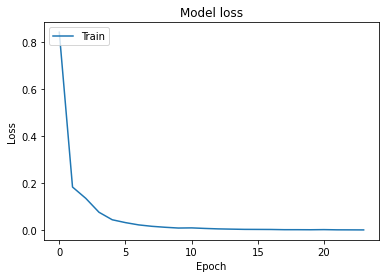

In [9]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

Now we give the confusion matrix for the testing.

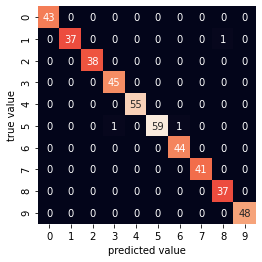

In [10]:
mat = confusion_matrix(pred, y_compare)

#using seaborn 
sns.heatmap(mat, square=True, annot=True, cbar=False)
plt.xlabel('predicted value')
plt.ylabel('true value');

Finally, save the model for future use.

In [11]:
# Save model and weights
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at ./ex8Part1_trained_model.h5 
